# Imports and setup

In [1]:
########## 1. Import required libraries ##########

import pandas as pd
import numpy as np
import re
import math
import pandas as pd
import matplotlib.pyplot as plt

# Text and feature engineering
from sklearn.feature_extraction.text import TfidfVectorizer

# Evaluation and tuning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_curve, auc, classification_report)

# Classifiers
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE

# Text cleaning & stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chibu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Step 1: Preprocess and Save Processed Data to CSV 

##### Functions to preprocess data

In [2]:
########## 2. Define text preprocessing methods ##########

def remove_html(text):
    """Remove HTML tags using a regex."""
    html = re.compile(r'<.*?>')
    return html.sub(r'', text)

def remove_emoji(text):
    """Remove emojis using a regex pattern."""
    emoji_pattern = re.compile("[" u"\U0001F600-\U0001F64F"  
                               u"\U0001F300-\U0001F5FF"  
                               u"\U0001F680-\U0001F6FF"  
                               u"\U0001F1E0-\U0001F1FF"  
                               u"\U00002702-\U000027B0"  
                               u"\U000024C2-\U0001F251" "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    custom_stopwords = {}  # Define your custom stopwords here
    stop_words.update(custom_stopwords)
    return " ".join([word for word in text.split() if word.lower() not in stop_words])

def clean_str(string):
    """
    Clean text by removing non-alphanumeric characters,
    and convert it to lowercase.
    """
    string = re.sub(r"[^A-Za-z0-9(),.!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"\)", " ) ", string)
    string = re.sub(r"\?", " ? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    string = re.sub(r"\\", "", string)
    string = re.sub(r"\'", "", string)
    string = re.sub(r"\"", "", string)
    return string.strip().lower()

def check_data_leakage(X_train, X_test):
    train_set = set(map(tuple, X_train))
    test_set = set(map(tuple, X_test))

    leaked_samples = train_set.intersection(test_set)
    print("\n🔍 Checking Data Leakage...")
    print(f"⚠️ {len(leaked_samples)} samples from test data are also in training data.")

    if len(leaked_samples) > 0:
        print("❌ Data Leakage Detected! Test data should not exist in training set.")
    else:
        print("✅ No Data Leakage Detected.")

##COMAPRES TEST ACCURACY TO TRAIN ACCURACY
def check_overfitting(model, X_train, y_train, X_test, y_test):
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    train_acc = accuracy_score(y_train, train_preds)
    test_acc = accuracy_score(y_test, test_preds)
    
    print("\n🔍 Checking Overfitting...")
    print(f"📊 Training Accuracy: {train_acc:.4f}")
    print(f"📊 Test Accuracy: {test_acc:.4f}")

    if train_acc > test_acc + 0.10:
        print("❌ Possible Overfitting: Model performs much better on training data.")
    else:
        print("✅ No significant overfitting detected.")

# Line Chart (Trend over Repeats)
def plot_metric_trends(csv_path):
    df = pd.read_csv(csv_path)
    plt.figure(figsize=(8, 4))
    metric_columns = ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']

    for metric in metric_columns:
        plt.plot(df['Repeat'], df[metric], marker='o', label=metric)

    # Chart styling
    plt.xlabel("Repeat")
    plt.ylabel("Score")
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(metric_columns), frameon=False)
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

##### Download and read data, save to csv files for repeatable use

In [3]:
########## 3. Download & read data ##########
project = 'keras'
text_col = 'Title+Body'


In [5]:
path = f'C:/Users/chibu/Documents/ISE-solution-main/Coursework/datasets/{project}.csv'

data = pd.read_csv(path).fillna('')
data['Title+Body'] = data.apply(lambda row: row['Title'] + '. ' + row['Body'] if pd.notna(row['Body']) else row['Title'], axis=1)
#text_col = 'Title+Body'

data[text_col] = data[text_col].apply(remove_html)
data[text_col] = data[text_col].apply(remove_emoji)
data[text_col] = data[text_col].apply(remove_stopwords)
data[text_col] = data[text_col].apply(clean_str)

data.to_csv(f'{project}_processed_data.csv', index=False)


##### Load and check datasets in Title+Body Files

In [5]:
baseline_path = 'C:/Users/chibu/Documents/ISE-solution-main/Coursework/trial2'

df = pd.read_csv(f'{project}_processed_data.csv')
df.head()

,Unnamed: 0,Repository,Number,State,Title,Body,Labels,Comments,Codes,Commands,class,related,Title+Body
0,0,keras,11776,closed,Improve performance (GPU utilization) of `mult...,Improve performance (GPU utilization) of for ...,Enhancement stat:contributions welcome,"[""Based on the measurements it seems that two...",[],['multi_gpu_model'],1,0,improve performance (gpu utilization ) `multi ...
1,1,keras,8707,closed,Good accuracy on test data but bad prediction ...,[Deleted],NaN,[],[],[],1,0,good accuracy test data bad prediction behavio...
2,2,keras,11267,closed,"model.fit very slow validation, more evident w...",I have a similar problem of this old [issue](h...,type:support,['I’m encountering the same issue on GPU with ...,[],['pip install git+git://github.com/keras-team/...,1,0,"model.fit slow validation, evident intel phi. ..."
3,3,keras,511,closed,Very low or NaN accuracy in the examples when ...,I've been trying all the MNIST examples from t...,NaN,['All these examples work fine on my GT650M on...,[],[],1,0,low nan accuracy examples running gpu float32....
4,4,keras,12812,closed,"Validation loss >> train loss, same data","Training a GRU autoencoder on EEG data, I disc...",NaN,[],"['(300,80,150)', '(encoder, latent, decoder)',...",[],1,0,"validation loss train loss, data. training gru..."


### Step 2: Configure parameters and start training

##### Set values, params and load csv files

In [7]:
# Number of repeated experiments
REPEAT = 30

# Output CSV file name
results_dir = "C:/Users/chibu/Documents/ISE-solution-main/Coursework/trial2/results"
out_csv_name = f"{results_dir}/{project}_Results.csv"

# Convert and save metrics for all models
def save_model_metrics(metrics_list, filename):
    df = pd.DataFrame(metrics_list)
    df.to_csv(f"{results_dir}/{filename}", index=False)
    print(f"Saved: {filename}")
    print(df.mean(numeric_only=True))
    print("\n")

# Hyperparameter grid for Naive Bayes
params = {'var_smoothing': np.logspace(-12, 0, 13)}

# Lists to store metrics across repeated runs
accuracies, precisions, recalls, f1_scores, auc_values = [], [], [], [], []

##### Perform Testing on Baseline code from Lab 1

In [8]:
nb_metrics = []
# Load dataset for this iteration
data = pd.read_csv(f'{project}_processed_data.csv')
X = data[text_col]
y = data['class']

for repeated_time in range(REPEAT):
    

    # Train-test split (70/30)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=repeated_time, shuffle=True
    )

    # Apply TF-IDF vectorization
    tfidf = TfidfVectorizer(ngram_range=(1, 2), max_features=1000)
    X_train_tfidf = tfidf.fit_transform(X_train).toarray()
    X_test_tfidf = tfidf.transform(X_test).toarray()

    # Train and Evaluate Naive Bayes with Cross-Validation
    nb_clf = GaussianNB()
    grid = GridSearchCV(nb_clf, params, cv=5, scoring='roc_auc')
    grid.fit(X_train_tfidf, y_train)
    best_nb = grid.best_estimator_
    y_pred_nb = best_nb.predict(X_test_tfidf)
    
    nb_metrics.append({
        "Repeat": repeated_time,
        "Accuracy": accuracy_score(y_test, y_pred_nb),
        "Precision": precision_score(y_test, y_pred_nb, average='macro'),
        "Recall": recall_score(y_test, y_pred_nb, average='macro'),
        "F1": f1_score(y_test, y_pred_nb, average='macro'),
        "AUC": auc(*roc_curve(y_test, y_pred_nb, pos_label=1)[:2])
    })

    save_model_metrics(nb_metrics, f'{project}_NaiveBayes_Metrics.csv')

Saved: keras_NaiveBayes_Metrics.csv
Repeat       0.000000
Accuracy     0.611940
Precision    0.638811
Recall       0.720323
F1           0.582943
AUC          0.720323
dtype: float64


Saved: keras_NaiveBayes_Metrics.csv
Repeat       0.500000
Accuracy     0.567164
Precision    0.636570
Recall       0.700458
F1           0.548913
AUC          0.700458
dtype: float64


Saved: keras_NaiveBayes_Metrics.csv
Repeat       1.000000
Accuracy     0.577114
Precision    0.635639
Recall       0.703993
F1           0.556087
AUC          0.703993
dtype: float64


Saved: keras_NaiveBayes_Metrics.csv
Repeat       1.500000
Accuracy     0.572139
Precision    0.643354
Recall       0.703495
F1           0.555474
AUC          0.703495
dtype: float64


Saved: keras_NaiveBayes_Metrics.csv
Repeat       2.000000
Accuracy     0.573134
Precision    0.640691
Recall       0.702486
F1           0.555545
AUC          0.702486
dtype: float64


Saved: keras_NaiveBayes_Metrics.csv
Repeat       2.500000
Accuracy     0.57

##### View progressive results

In [9]:
df = pd.read_csv(f'{baseline_path}/results/{project}_NaiveBayes_Metrics.csv')
df.head() 

,Repeat,Accuracy,Precision,Recall,F1,AUC
0,0,0.611940,0.638811,0.720323,0.582943,0.720323
1,1,0.522388,0.634328,0.680593,0.514883,0.680593
2,2,0.597015,0.633778,0.711064,0.570433,0.711064
3,3,0.557214,0.666498,0.702002,0.553634,0.702002
4,4,0.577114,0.630037,0.698447,0.555830,0.698447


##### Save final results to csv file

In [10]:
# === Calculate final averages from all repeats ===
final_metrics = {
    "Total_Repeats": REPEAT,
    "Avg_Accuracy": np.mean([m["Accuracy"] for m in nb_metrics]),
    "Avg_Precision": np.mean([m["Precision"] for m in nb_metrics]),
    "Avg_Recall": np.mean([m["Recall"] for m in nb_metrics]),
    "Avg_F1": np.mean([m["F1"] for m in nb_metrics]),
    "Avg_AUC": np.mean([m["AUC"] for m in nb_metrics])
}

save_model_metrics([final_metrics], f'{project}_NaiveBayes_Final_Metrics.csv')

Saved: keras_NaiveBayes_Final_Metrics.csv
Total_Repeats    30.000000
Avg_Accuracy      0.574461
Avg_Precision     0.640223
Avg_Recall        0.709623
Avg_F1            0.555765
Avg_AUC           0.709623
dtype: float64




##### Load results for baseline 

In [11]:
df = pd.read_csv(f'{baseline_path}/results/{project}_NaiveBayes_Final_Metrics.csv')
df.head() 

,Total_Repeats,Avg_Accuracy,Avg_Precision,Avg_Recall,Avg_F1,Avg_AUC
0,30,0.574461,0.640223,0.709623,0.555765,0.709623


### Examine datasets for data leakage and overfitting and class ditribution to know what to expect when it comes to validating my results based on baseline

In [12]:


#check where these variables are coming from
# For baseline Naive Bayes testing:
check_data_leakage(X_train_tfidf, X_test_tfidf)
check_overfitting(best_nb, X_train_tfidf, y_train, X_test_tfidf, y_test)

print("\nClass Distribution in Training Set:")
print(y_train.value_counts())
print("\nClassification Report (Naive Bayes):")
print(classification_report(y_test, y_pred_nb))


🔍 Checking Data Leakage...
⚠️ 2 samples from test data are also in training data.
❌ Data Leakage Detected! Test data should not exist in training set.

🔍 Checking Overfitting...
📊 Training Accuracy: 0.6681
📊 Test Accuracy: 0.6070
✅ No significant overfitting detected.

Class Distribution in Training Set:
class
0    374
1     93
Name: count, dtype: int64

Classification Report (Naive Bayes):
              precision    recall  f1-score   support

           0       0.99      0.51      0.67       159
           1       0.34      0.98      0.51        42

    accuracy                           0.61       201
   macro avg       0.67      0.74      0.59       201
weighted avg       0.85      0.61      0.64       201



##### Line chart Reapeats

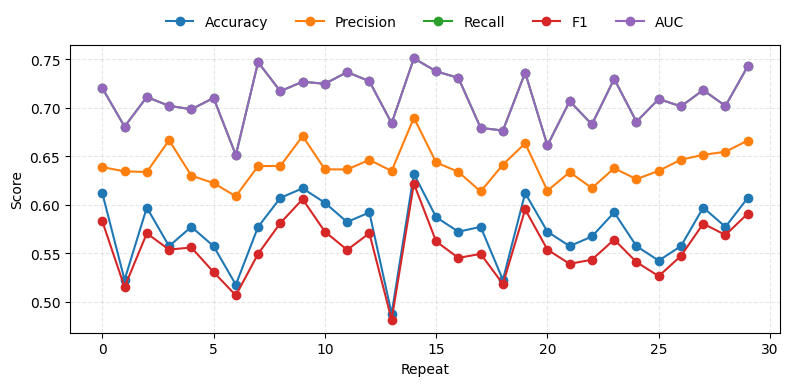

In [6]:
plot_metric_trends(f'{baseline_path}/results/{project}_NaiveBayes_Metrics.csv')

##### Perform Testing with Random Forest

In [13]:
rf_metrics = []

# Load dataset for this iteration
data_rf = pd.read_csv(f'{project}_processed_data.csv')
X_rf = data_rf[text_col]
y_rf = data_rf['class']

for repeated_time in range(REPEAT):
    
    # Train-test split (70/30)
    X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(
        X_rf, y_rf, test_size=0.3, random_state=repeated_time, shuffle=True
    )

    # Apply TF-IDF vectorization
    tfidf_rf = TfidfVectorizer(ngram_range=(1, 2), max_features=1000)
    X_train_tfidf_rf = tfidf_rf.fit_transform(X_train_rf).toarray()
    X_test_tfidf_rf = tfidf_rf.transform(X_test_rf).toarray()

    # Train and Evaluate Random Forest
    rf_clf = RandomForestClassifier(n_estimators=100, max_depth=20)
    rf_clf.fit(X_train_tfidf_rf, y_train_rf)
    y_pred_rf = rf_clf.predict(X_test_tfidf_rf)

    rf_metrics.append({
        "Repeat": repeated_time,
        "Accuracy": accuracy_score(y_test_rf, y_pred_rf),
        "Precision": precision_score(y_test_rf, y_pred_rf, average='macro'),
        "Recall": recall_score(y_test_rf, y_pred_rf, average='macro'),
        "F1": f1_score(y_test_rf, y_pred_rf, average='macro'),
        "AUC": auc(*roc_curve(y_test_rf, y_pred_rf, pos_label=1)[:2])
    })

    save_model_metrics(rf_metrics, f'{project}_RandomForest_Metrics.csv')


Saved: keras_RandomForest_Metrics.csv
Repeat       0.000000
Accuracy     0.850746
Precision    0.848609
Recall       0.634853
F1           0.668681
AUC          0.634853
dtype: float64


Saved: keras_RandomForest_Metrics.csv
Repeat       0.500000
Accuracy     0.845771
Precision    0.848483
Recall       0.635710
F1           0.668362
AUC          0.635710
dtype: float64


Saved: keras_RandomForest_Metrics.csv
Repeat       1.000000
Accuracy     0.845771
Precision    0.845638
Recall       0.631151
F1           0.662881
AUC          0.631151
dtype: float64


Saved: keras_RandomForest_Metrics.csv
Repeat       1.500000
Accuracy     0.830846
Precision    0.819836
Recall       0.618533
F1           0.643284
AUC          0.618533
dtype: float64


Saved: keras_RandomForest_Metrics.csv
Repeat       2.000000
Accuracy     0.833831
Precision    0.830988
Recall       0.619205
F1           0.645011
AUC          0.619205
dtype: float64


Saved: keras_RandomForest_Metrics.csv
Repeat       2.500000
Accur

##### Save results to csv file

In [14]:
# === Calculate final averages from all repeats ===
final_metrics = {
    "Total_Repeats": REPEAT,
    "Avg_Accuracy": np.mean([m["Accuracy"] for m in rf_metrics]),
    "Avg_Precision": np.mean([m["Precision"] for m in rf_metrics]),
    "Avg_Recall": np.mean([m["Recall"] for m in rf_metrics]),
    "Avg_F1": np.mean([m["F1"] for m in rf_metrics]),
    "Avg_AUC": np.mean([m["AUC"] for m in rf_metrics])
}

save_model_metrics([final_metrics], f'{project}_RandomForest_Final_Metrics.csv')

Saved: keras_RandomForest_Final_Metrics.csv
Total_Repeats    30.000000
Avg_Accuracy      0.835489
Avg_Precision     0.823888
Avg_Recall        0.613556
Avg_F1            0.635602
Avg_AUC           0.613556
dtype: float64




##### Load results for Random Forest 

In [15]:
df = pd.read_csv(f'{baseline_path}/results/{project}_RandomForest_Final_Metrics.csv')
df.head() 

,Total_Repeats,Avg_Accuracy,Avg_Precision,Avg_Recall,Avg_F1,Avg_AUC
0,30,0.835489,0.823888,0.613556,0.635602,0.613556


##### Line chart repeats

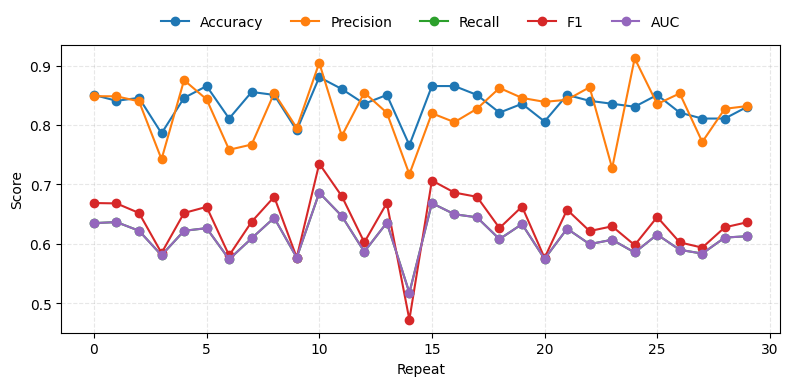

In [7]:
plot_metric_trends(f'{baseline_path}/results/{project}_RandomForest_Metrics.csv')

##### My own improvement: perform testing with the hybrid Model 

In [16]:
hybrid_metrics = []
# Load dataset for this iteration
data = pd.read_csv(f'{project}_processed_data.csv')
X_hybrid = data[text_col]
y_hybrid = data['class']

for repeated_time in range(REPEAT):
    

    X_train_hybrid, X_test_hybrid, y_train_hybrid, y_test_hybrid = train_test_split(
        X_hybrid, y_hybrid, test_size=0.3, random_state=repeated_time, shuffle=True
    )

    tfidf_hybrid = TfidfVectorizer(ngram_range=(1, 2), max_features=1000)
    X_train_tfidf_hybrid = tfidf_hybrid.fit_transform(X_train_hybrid).toarray()
    X_test_tfidf_hybrid = tfidf_hybrid.transform(X_test_hybrid).toarray()

    rf_clf_hybrid = RandomForestClassifier(n_estimators=100, max_depth=20)
    rf_clf_hybrid.fit(X_train_tfidf_hybrid, y_train_hybrid)

    logreg_clf_hybrid = LogisticRegression(max_iter=2000)
    voting_clf_hybrid = VotingClassifier(estimators=[('rf', rf_clf_hybrid), ('logreg', logreg_clf_hybrid)], voting='soft')
    voting_clf_hybrid.fit(X_train_tfidf_hybrid, y_train_hybrid)

    y_pred_hybrid = voting_clf_hybrid.predict(X_test_tfidf_hybrid)

    hybrid_metrics.append({
        "Repeat": repeated_time,
        "Accuracy": accuracy_score(y_test_hybrid, y_pred_hybrid),
        "Precision": precision_score(y_test_hybrid, y_pred_hybrid, average='macro'),
        "Recall": recall_score(y_test_hybrid, y_pred_hybrid, average='macro'),
        "F1": f1_score(y_test_hybrid, y_pred_hybrid, average='macro'),
        "AUC": auc(*roc_curve(y_test_hybrid, y_pred_hybrid, pos_label=1)[:2])
    })

    save_model_metrics(hybrid_metrics, f'{project}_HybridModel_Metrics.csv')


Saved: keras_HybridModel_Metrics.csv
Repeat       0.000000
Accuracy     0.830846
Precision    0.843520
Recall       0.573837
F1           0.582682
AUC          0.573837
dtype: float64


Saved: keras_HybridModel_Metrics.csv
Repeat       0.500000
Accuracy     0.830846
Precision    0.877718
Recall       0.584537
F1           0.597193
AUC          0.584537
dtype: float64


Saved: keras_HybridModel_Metrics.csv
Repeat       1.000000
Accuracy     0.835821
Precision    0.875634
Recall       0.593791
F1           0.611384
AUC          0.593791
dtype: float64


Saved: keras_HybridModel_Metrics.csv
Repeat       1.500000
Accuracy     0.823383
Precision    0.846319
Recall       0.588726
F1           0.601765
AUC          0.588726
dtype: float64


Saved: keras_HybridModel_Metrics.csv
Repeat       2.000000
Accuracy     0.823881
Precision    0.859198
Recall       0.583480
F1           0.593831
AUC          0.583480
dtype: float64


Saved: keras_HybridModel_Metrics.csv
Repeat       2.500000
Accuracy   

##### Save results to csv file

In [17]:
# === Calculate final averages from all repeats ===
final_metrics = {
    "Total_Repeats": REPEAT,
    "Avg_Accuracy": np.mean([m["Accuracy"] for m in hybrid_metrics]),
    "Avg_Precision": np.mean([m["Precision"] for m in hybrid_metrics]),
    "Avg_Recall": np.mean([m["Recall"] for m in hybrid_metrics]),
    "Avg_F1": np.mean([m["F1"] for m in hybrid_metrics]),
    "Avg_AUC": np.mean([m["AUC"] for m in hybrid_metrics])
}

save_model_metrics([final_metrics], f'{project}_HybridModel_Final_Metrics.csv')

Saved: keras_HybridModel_Final_Metrics.csv
Total_Repeats    30.000000
Avg_Accuracy      0.825373
Avg_Precision     0.837385
Avg_Recall        0.577065
Avg_F1            0.584304
Avg_AUC           0.577065
dtype: float64




##### Load results for Hybrid Model 

In [18]:
df = pd.read_csv(f'{baseline_path}/results/{project}_HybridModel_Final_Metrics.csv')
df.head() 

,Total_Repeats,Avg_Accuracy,Avg_Precision,Avg_Recall,Avg_F1,Avg_AUC
0,30,0.825373,0.837385,0.577065,0.584304,0.577065


##### Line chart Repeats

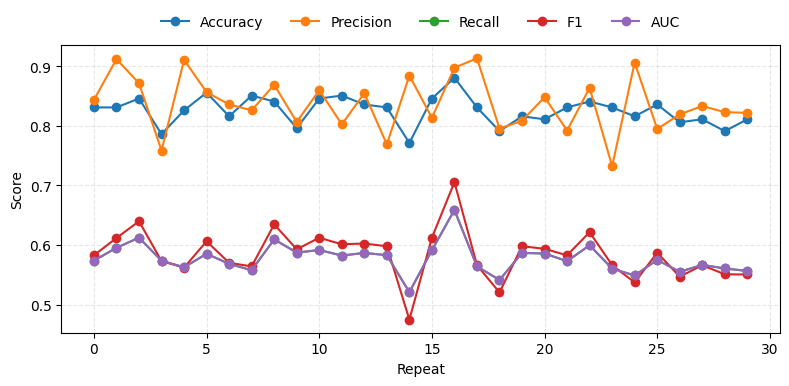

In [8]:
plot_metric_trends(f'{baseline_path}/results/{project}_HybridModel_Metrics.csv')

### Step 3: Validate results

###### Now that the training has been complete with the baselineto be able to compare with my own improvements. 
###### I want to ensure my results can be trusted so, FOR THE HYBRID MODEL, I will test on holdout data, check for data leakage an overfitting. I will also check the class distribution of the training set and perfrom SMOTE to Balance the dataset and retest witht the hybrid model, to see if there any differences in results

##### Test Hybrid Model on Holdout Data ---Shoukld this repeat 30 times???

In [19]:
###0 IS A NONBUG, SO IT IS WHAT SHOULD BE PRE4DICTED AS NONBUG

# Define function to test trained hybrid model on holdout set
def test_on_holdout_hybrid(model):
    holdout_data_hybrid = pd.read_csv(f'{project}_processed_data_holdout.csv')
    holdout_text_hybrid = holdout_data_hybrid[text_col]
    holdout_labels_hybrid = holdout_data_hybrid['class']

    tfidf_hybrid_holdout = TfidfVectorizer(ngram_range=(1, 2), max_features=1000)
    X_holdout_hybrid = tfidf_hybrid_holdout.fit_transform(holdout_text_hybrid).toarray()

    holdout_preds_hybrid = model.predict(X_holdout_hybrid)
    print("\n🔍 Holdout Set Performance (Hybrid Model):")
    print(classification_report(holdout_labels_hybrid, holdout_preds_hybrid, target_names=['Non-Bug', 'Bug']))

    # Load full processed dataset
data = pd.read_csv(f'{project}_processed_data.csv')

# Create holdout split (90% train/test, 10% holdout)
train_test_data, holdout_data = train_test_split(data, test_size=0.1, random_state=42)

# Save to CSV for consistent usage across notebooks
train_test_data.to_csv(f'{project}_processed_train_test_data_holdout.csv', index=False)
holdout_data.to_csv(f'{project}_processed_data_holdout.csv', index=False)




hybrid_holdout_metrics = []

# Load 90% dataset for training/testing splits
data_hybrid_holdout = pd.read_csv(f'{project}_processed_train_test_data_holdout.csv')
X_hybrid_holdout = data_hybrid_holdout[text_col]
y_hybrid_holdout = data_hybrid_holdout['class']

for repeated_time in range(REPEAT):
    # Split into 70/30
    X_train_hybrid, X_test_hybrid, y_train_hybrid, y_test_hybrid = train_test_split(
        X_hybrid_holdout, y_hybrid_holdout, test_size=0.3, random_state=repeated_time, shuffle=True
    )

    # TF-IDF
    tfidf_hybrid = TfidfVectorizer(ngram_range=(1, 2), max_features=1000)
    X_train_tfidf_hybrid = tfidf_hybrid.fit_transform(X_train_hybrid).toarray()
    X_test_tfidf_hybrid = tfidf_hybrid.transform(X_test_hybrid).toarray()

    # Random Forest
    rf_clf_hybrid = RandomForestClassifier(n_estimators=100, max_depth=20)
    rf_clf_hybrid.fit(X_train_tfidf_hybrid, y_train_hybrid)

    # Hybrid Model: Random Forest + Logistic Regression
    logreg_clf_hybrid = LogisticRegression(max_iter=2000)
    voting_clf_hybrid = VotingClassifier(estimators=[
        ('rf', rf_clf_hybrid), 
        ('logreg', logreg_clf_hybrid)
    ], voting='soft')
    voting_clf_hybrid.fit(X_train_tfidf_hybrid, y_train_hybrid)
    y_pred_hybrid = voting_clf_hybrid.predict(X_test_tfidf_hybrid)

    # Save metrics for each repeat
    hybrid_holdout_metrics.append({
        "Repeat": repeated_time,
        "Accuracy": accuracy_score(y_test_hybrid, y_pred_hybrid),
        "Precision": precision_score(y_test_hybrid, y_pred_hybrid, average='macro'),
        "Recall": recall_score(y_test_hybrid, y_pred_hybrid, average='macro'),
        "F1": f1_score(y_test_hybrid, y_pred_hybrid, average='macro'),
        "AUC": auc(*roc_curve(y_test_hybrid, y_pred_hybrid, pos_label=1)[:2])
    })

# Save all repeated metrics to CSV
#save_model_metrics(hybrid_holdout_metrics, f'{project}_HybridModel_Holdout_Metrics.csv')



# Evaluate on true holdout portion
test_on_holdout_hybrid(voting_clf_hybrid)



🔍 Holdout Set Performance (Hybrid Model):
              precision    recall  f1-score   support

     Non-Bug       0.76      1.00      0.86        51
         Bug       0.00      0.00      0.00        16

    accuracy                           0.76        67
   macro avg       0.38      0.50      0.43        67
weighted avg       0.58      0.76      0.66        67



c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


##### Save results to csv file

In [20]:
## Save results here

##### Load results for test on holdout

In [21]:
#df = pd.read_csv("processed_data_holdout.csv")
#df.head() 

##### Check for data leakage and overfitting

In [22]:
#check where these variables are coming from
check_data_leakage(X_train_tfidf_hybrid, X_test_tfidf_hybrid)
check_overfitting(voting_clf_hybrid, X_train_tfidf_hybrid, y_train_hybrid, X_test_tfidf_hybrid, y_test_hybrid)


🔍 Checking Data Leakage...
⚠️ 0 samples from test data are also in training data.
✅ No Data Leakage Detected.

🔍 Checking Overfitting...
📊 Training Accuracy: 0.9571
📊 Test Accuracy: 0.8564
❌ Possible Overfitting: Model performs much better on training data.


##### Check class distribution 

In [23]:
print("\nClass Distribution in Training Set:")
print(y_train_hybrid.value_counts())
print("\nClassification Report:")
print(classification_report(y_test_hybrid, y_pred_hybrid))


Class Distribution in Training Set:
class
0    328
1     92
Name: count, dtype: int64

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.99      0.92       154
           1       0.67      0.07      0.13        27

    accuracy                           0.86       181
   macro avg       0.76      0.53      0.53       181
weighted avg       0.83      0.86      0.80       181



##### Perform Smote to Balance Dataset and Test Hybrid Model 

In [24]:
smote_hybrid_metrics = []

# Load dataset for SMOTE-based training
data_smote_hybrid = pd.read_csv(f'{project}_processed_data.csv')
X_smote_hybrid = data_smote_hybrid[text_col]
y_smote_hybrid = data_smote_hybrid['class']

for repeated_time in range(REPEAT):
    # Train-test split (70/30)
    X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(
        X_smote_hybrid, y_smote_hybrid, test_size=0.3, random_state=repeated_time, shuffle=True
    )

    # TF-IDF vectorization
    tfidf_smote = TfidfVectorizer(ngram_range=(1, 2), max_features=1000)
    X_train_tfidf_smote = tfidf_smote.fit_transform(X_train_smote).toarray()
    X_test_tfidf_smote = tfidf_smote.transform(X_test_smote).toarray()

    # Train Hybrid Model
    rf_clf_smote = RandomForestClassifier(n_estimators=100, max_depth=20)
    logreg_clf_smote = LogisticRegression(max_iter=2000)
    hybrid_clf_smote = VotingClassifier(
        estimators=[('rf', rf_clf_smote), ('logreg', logreg_clf_smote)],
        voting='soft'
    )

    # Apply SMOTE to balance training data
    smote = SMOTE()
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train_tfidf_smote, y_train_smote)

    # Train on balanced data
    hybrid_clf_smote.fit(X_train_balanced, y_train_balanced)

    # Predict on original (unbalanced) test set
    y_pred_smote_hybrid = hybrid_clf_smote.predict(X_test_tfidf_smote)

    # Collect metrics
    smote_hybrid_metrics.append({
        "Repeat": repeated_time,
        "Accuracy": accuracy_score(y_test_smote, y_pred_smote_hybrid),
        "Precision": precision_score(y_test_smote, y_pred_smote_hybrid, average='macro'),
        "Recall": recall_score(y_test_smote, y_pred_smote_hybrid, average='macro'),
        "F1": f1_score(y_test_smote, y_pred_smote_hybrid, average='macro'),
        "AUC": auc(*roc_curve(y_test_smote, y_pred_smote_hybrid, pos_label=1)[:2])
    })

# Save metrics after all repeats
save_model_metrics(smote_hybrid_metrics, f'{project}_SMOTE_HybridModel_Metrics.csv')


Saved: keras_SMOTE_HybridModel_Metrics.csv
Repeat       14.500000
Accuracy      0.866169
Precision     0.799825
Recall        0.767070
F1            0.779187
AUC           0.767070
dtype: float64




##### Save and load results

In [25]:
# === Calculate final averages from all repeats ===
final_metrics = {
    "Total_Repeats": REPEAT,
    "Avg_Accuracy": np.mean([m["Accuracy"] for m in smote_hybrid_metrics]),
    "Avg_Precision": np.mean([m["Precision"] for m in smote_hybrid_metrics]),
    "Avg_Recall": np.mean([m["Recall"] for m in smote_hybrid_metrics]),
    "Avg_F1": np.mean([m["F1"] for m in smote_hybrid_metrics]),
    "Avg_AUC": np.mean([m["AUC"] for m in smote_hybrid_metrics])
}

save_model_metrics([final_metrics], f'{project}_SMOTE_HybridModel_Final_Metrics.csv')

Saved: keras_SMOTE_HybridModel_Final_Metrics.csv
Total_Repeats    30.000000
Avg_Accuracy      0.866169
Avg_Precision     0.799825
Avg_Recall        0.767070
Avg_F1            0.779187
Avg_AUC           0.767070
dtype: float64




In [26]:
df = pd.read_csv(f'{baseline_path}/results/{project}_SMOTE_HybridModel_Final_Metrics.csv')
df.head() 

,Total_Repeats,Avg_Accuracy,Avg_Precision,Avg_Recall,Avg_F1,Avg_AUC
0,30,0.866169,0.799825,0.76707,0.779187,0.76707


In [ ]:
# ✅ Data Leakage Check (only makes sense for original training data before SMOTE)
check_data_leakage(X_train_tfidf_smote, X_test_tfidf_smote)

# ✅ Overfitting Check (use SMOTE-balanced training data and unbalanced test data)
check_overfitting(hybrid_clf_smote, X_train_balanced, y_train_balanced, X_test_tfidf_smote, y_test_smote)

# ✅ Class Distribution
print("\nOriginal Class Distribution in Training Set (Before SMOTE):")
print(y_train_smote.value_counts())

print("\nBalanced Class Distribution After SMOTE:")
print(pd.Series(y_train_balanced).value_counts())

# ✅ Classification Report
print("\nClassification Report (SMOTE Hybrid Model):")
print(classification_report(y_test_smote, y_pred_smote_hybrid))


🔍 Checking Data Leakage...
⚠️ 2 samples from test data are also in training data.
❌ Data Leakage Detected! Test data should not exist in training set.

🔍 Checking Overfitting...
📊 Training Accuracy: 0.9973
📊 Test Accuracy: 0.8856
❌ Possible Overfitting: Model performs much better on training data.

Original Class Distribution in Training Set (Before SMOTE):
class
0    374
1     93
Name: count, dtype: int64

Balanced Class Distribution After SMOTE:
class
0    374
1    374
Name: count, dtype: int64

Classification Report (SMOTE Hybrid Model):
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       159
           1       0.79      0.62      0.69        42

    accuracy                           0.89       201
   macro avg       0.85      0.79      0.81       201
weighted avg       0.88      0.89      0.88       201



: 